In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-09-12 03:47:56--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-12 03:47:57--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc55032fa98247a681b2e948049.dl.dropboxusercontent.com/cd/0/get/Bszo02bhozzvbRR52_m51fSkutFU5cjXpqd81RlDqem91SXI_qFN4doADI6llZvyt7VDo0VIHEVfo-G10zIALYZIjak6v_yFHMC0zCDgL966rw3Wo5BBN9PVQzn34QoNIdjzIQMhaf5_32X4VB4hf10YAZgMWtXCcngFZONiTpp2Diac-mJ0T5fmOCEHTkPul50/file?dl=1# [following]
--2022-09-12 03:47:57--  https://ucc55032fa98247a681b2e948049.dl.dropboxusercontent.com/cd/0/get/Bszo02bhoz

In [ ]:
!nltk

Usage: nltk [OPTIONS] COMMAND [ARGS]...

Options:
  --version   Show the version and exit.
  -h, --help  Show this message and exit.

Commands:
  tokenize  This command tokenizes text stream...


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM, Input, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from konlpy.tag import Mecab
from nltk.tokenize import word_tokenize

## Download the data


In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 134MB/s]


In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


## Configuration

In [ ]:
batch_size = 64
epochs = 100
hidden_units = 256
embedding_dim = 64
num_samples = 200000

## Prepare the data

In [ ]:
mecab = Mecab()

In [ ]:
src_ls = df['원문'].to_list()
len(src_ls)

200000

In [ ]:
trg_ls = df['번역문'].to_list()
len(trg_ls)

200000

In [ ]:
encoder_input = []
for src in src_ls:
  re_src = re.sub('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ\?\!\.\,\\s]','', src)
  encoder_input.append(mecab.morphs(re_src))

len(encoder_input)

200000

In [ ]:
decoder_input = []
decoder_target = []

for trg in trg_ls:
  re_trg = re.sub('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ\?\!\.\,\\s]','', trg)
  re_trg_in = re_trg
  re_trg_out = re_trg
  decoder_input.append(['<sos>'] + word_tokenize(re_trg_in))
  decoder_target.append(word_tokenize(re_trg_out) + ["<eos>"])
print(decoder_input[:10])
print(decoder_target[:10])

[['<sos>', 'Bible', 'Coloring', 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 'experience', 'beautiful', 'stories', 'in', 'the', 'Bible', '.'], ['<sos>', 'Do', 'you', 'work', 'at', 'a', 'City', 'bank', '?'], ['<sos>', 'PURITOs', 'bestseller', ',', 'which', 'recorded', 'th', 'rough', 'cuts', 'by', 'words', 'of', 'mouth', 'from', 'abroad', '.'], ['<sos>', 'In', 'Chapter', 'Jesus', 'called', 'Lazarus', 'from', 'the', 'tomb', 'and', 'raised', 'him', 'from', 'the', 'dead', '.'], ['<sos>', 'I', 'would', 'feel', 'grateful', 'to', 'know', 'how', 'many', 'stocks', 'will', 'be', 'secured', 'of', 'size', '.', ',', ',', 'and', '.'], ['<sos>', 'fw', 'Kenzo', 'Tiger', 'Kids', ',', 'and', 'refund', 'for', 'lacking', 'quantity', 'of', 'Kids', 'which', 'was', 'ordered', 'this', 'time', '.'], ['<sos>', 'And', 'Ill', 'send', 'you', 'a', 'picture', 'of', 'me', 'and', 'my', 'dogs', '.'], ['<sos>', 'Part', 'of', 'profits', 'are', 'used', 'for', 'the', 'comfort', 'women', ',', 'and', '

In [ ]:
# 한국어
tokenizer_kor = Tokenizer(filters="", lower=False)
tokenizer_kor.fit_on_texts(encoder_input)

# 인코더 데이터
encoder_input = tokenizer_kor.texts_to_sequences(encoder_input)

In [ ]:
# 영어
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_target)

# 디코더 데이터
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_target = tokenizer_en.texts_to_sequences(decoder_target)

In [ ]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [ ]:
src_vocab_size = len(tokenizer_kor.word_index) + 1
tar_vocab_size = len(tokenizer_en.word_index) + 1

print(f"한글 단어 집합의 크기 : {src_vocab_size}, 영어 단어 집합의 크기 : {tar_vocab_size}")

한글 단어 집합의 크기 : 43746, 영어 단어 집합의 크기 : 46383


In [ ]:
src_to_index = tokenizer_kor.word_index
index_to_src = tokenizer_kor.index_word
tar_to_index = tokenizer_en.word_index
index_to_tar = tokenizer_en.index_word

In [ ]:
print(src_to_index)
print(index_to_src)

{'.': 1, '는': 2, '이': 3, '을': 4, '에': 5, '하': 6, '은': 7, '가': 8, '있': 9, '를': 10, '의': 11, '고': 12, '습니다': 13, '나': 14, '?': 15, '어요': 16, ',': 17, '한': 18, '들': 19, '어': 20, '것': 21, '당신': 22, '그': 23, '우리': 24, '에서': 25, '수': 26, '지': 27, '으로': 28, '주': 29, '도': 30, '게': 31, '내': 32, '저': 33, '했': 34, '기': 35, '었': 36, '입니다': 37, '할': 38, '해': 39, '되': 40, '로': 41, '합니다': 42, '과': 43, '않': 44, '좋': 45, '에게': 46, '해요': 47, '면': 48, '일': 49, '와': 50, '아': 51, '적': 52, '없': 53, '겠': 54, '다': 55, '에요': 56, '싶': 57, '사람': 58, '세요': 59, '거': 60, '보': 61, '시': 62, '같': 63, '생각': 64, '너': 65, '말': 66, '았': 67, '오늘': 68, '야': 69, '때': 70, '나요': 71, '인': 72, '받': 73, '많': 74, '만': 75, '잘': 76, '그녀': 77, '때문': 78, '친구': 79, '더': 80, '안': 81, '시간': 82, '지만': 83, '네': 84, '보내': 85, '중': 86, '아요': 87, '알': 88, '먹': 89, '한국': 90, '까지': 91, '사용': 92, '번': 93, '제품': 94, '여': 95, '해서': 96, '된': 97, '해야': 98, '서': 99, '집': 100, '다고': 101, '으면': 102, '많이': 103, '필요': 104, '라고': 105, '제': 106, '가지': 107,

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([   2,   82,  270,  582, 1095,    6,   77,  811, 2142,   11,  308,
          20,  116,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([  82,  270,  582, 1095,    6,   77,  811, 2142,   11,  308,   20,
         116,    1,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32))

## Modeling

In [ ]:
from tensorflow.keras.layers import Input

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) # 은닉 상태와 셀 상태를 리턴

encoder_states = [state_h, state_c]

In [ ]:
from tensorflow.keras.layers import Attention
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 임베딩 결과

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _ , _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
# attention
S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) # query 만들기

attention = Attention(hidden_units)
context_vector, _ = attention([ S_, encoder_outputs], return_attention_scores = True) # '_' 자리는 score 위치     encoder_outputs : key 와 value 

concat = tf.concat([decoder_outputs, context_vector], axis=-1) # S햇 완성

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, callbacks=[es], 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
1407/1407 [==============================] - 216s 148ms/step - loss: 1.4259 - acc: 0.8023 - val_loss: 1.1854 - val_acc: 0.8191
Epoch 2/50
1407/1407 [==============================] - 209s 148ms/step - loss: 1.1105 - acc: 0.8242 - val_loss: 1.0713 - val_acc: 0.8286
Epoch 3/50
1407/1407 [==============================] - 209s 148ms/step - loss: 1.0061 - acc: 0.8328 - val_loss: 1.0099 - val_acc: 0.8348
Epoch 4/50
1407/1407 [==============================] - 209s 148ms/step - loss: 0.9233 - acc: 0.8398 - val_loss: 0.9622 - val_acc: 0.8393
Epoch 5/50
1407/1407 [==============================] - 209s 148ms/step - loss: 0.8445 - acc: 0.8463 - val_loss: 0.9144 - val_acc: 0.8440
Epoch 6/50
1407/1407 [==============================] - 209s 148ms/step - loss: 0.7658 - acc: 0.8533 - val_loss: 0.8812 - val_acc: 0.8482
Epoch 7/50
1407/1407 [==============================] - 209s 149ms/step - loss: 0.6947 - acc: 0.8605 - val_loss: 0.8586 - val_acc: 0.8512
Epoch 8/50
1407/1407 [============

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

In [ ]:
# 디코더 
# decoder_inputs = Input(shape=(None, ))

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h, state_c]

# Attention
S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([decoder_outputs2, encoder_outputs2], return_attention_scores = True)
decoder_concat = tf.concat([S_, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

In [ ]:
max_src_len = encoder_input.shape[1]
max_tar_len = decoder_input.shape[1]

In [ ]:
def decode_sequence(sentence):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음

  attention_plot = np.zeros((max_tar_len, max_src_len))

  re_src = re.sub('[^A-Za-z가-힣ㄱ-ㅎㅏ-ㅣ\?\!\.\,\\s]','', sentence)
  sen = mecab.morphs(re_src)

  inputs = [tokenizer_kor.word_index[i] for i in sen]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_src_len,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  encoder_test, states_value = encoder_model.predict(inputs)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  for t in range(max_tar_len):
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

    # 어텐션 가중치 시각화를 위해 저장 
    att_score = tf.reshape(att_score, (-1, ))
    attention_plot[t] = att_score.numpy() 

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char


    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if sampled_char == '<eos>':
        break 

  return sentence, decoded_sentence, attention_plot

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: 아마도 당신 자신에게 물어봐야 할 것 같네요 .
Predicted translation:  I have to ask you to have some private money . <eos>


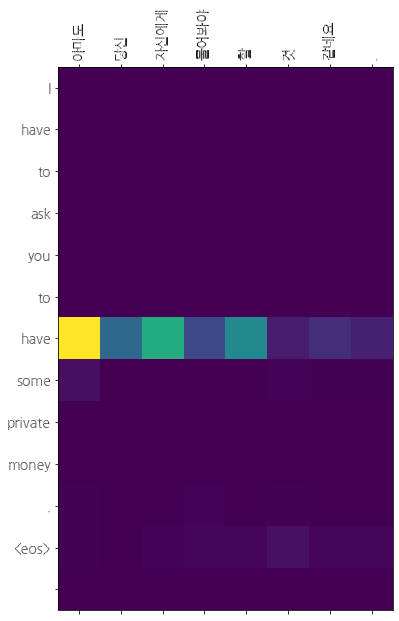

In [ ]:
translate(u'아마도 당신 자신에게 물어봐야 할 것 같네요 .')

## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다. 
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다. 
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명 
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

In [ ]:
import numpy as np
from collections import Counter
from nltk import ngrams

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. 

In [ ]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

패키지 NLTK의 BLEU : 0.5045666840058485


In [ ]:
ref_train = [seq_to_tar(sen) for sen in decoder_input_train[:100]]
ref_test = [seq_to_tar(sen) for sen in decoder_input_test[:100]]

In [ ]:
def translate_bleu(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)
  return result.strip(" <eos>")

In [ ]:
from tqdm.notebook import tqdm 

pred_test = []
for idx in tqdm(range(len(encoder_input_test[:100]))):
    pred_test.append(translate_bleu(idx))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
bleu_score = 0
for ref, pred in zip(ref_test, pred_test):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_test)
bleu_score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

1.361077635708999e-231

## Model Save

In [ ]:
model.save('/content/drive/MyDrive/trans_koreng_project/모델 결과저장/S2S_attention_model.h5')

## Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900